# 1. Load Data
------

In [2]:
!pip install kagglehub[pandas-datasets]
!pip install pandas
!pip install numpy
!pip install matplotlib
!pip install seaborn
!pip install statsmodels

In [22]:
import kagglehub
import os
# Store the path of the Kaggle dataset
path = kagglehub.dataset_download("jonassouza872/vitoria-da-conquista-weather-data-september")
# Check if the path is correct
print(path)

# List all files inside the downloaded folder
print(os.listdir(path))

Using Colab cache for faster access to the 'vitoria-da-conquista-weather-data-september' dataset.
/kaggle/input/vitoria-da-conquista-weather-data-september
['temp.csv']


In [23]:
import pandas as pd
df = pd.read_csv(f"{path}/temp.csv")  # Reads the declared path as a CSV file
df.head()  # Prints the first 5 rows of the dataset

,Timestamp,Temp_MPU6050_C,Temp_AHT20_C,Umid_AHT20_pct,Temp_BMP280_C,Press_BMP280_hPa,Temp_BMP180_C,Press_BMP180_hPa,Temp_DS18B20_C,Temp_NTC_C,Temp_DHT11_C,Umid_DHT11_pct
0,2025-08-31 22:31:02,20.86,19.90,73.37,21.28,921.24,20.19,923.02,25.69,22.26,20.03,66.0
1,2025-08-31 22:31:33,21.75,19.97,75.57,21.48,921.12,20.27,923.04,23.81,20.73,20.02,66.0
2,2025-08-31 22:32:05,21.80,19.75,74.31,21.25,921.20,20.16,923.06,22.50,20.88,20.02,67.0
3,2025-08-31 22:32:36,21.57,19.55,74.77,21.07,921.15,20.06,922.99,21.31,20.62,20.01,66.0
4,2025-08-31 22:33:07,21.66,19.60,75.09,21.12,921.25,20.06,923.02,21.88,20.95,20.00,66.0


In [24]:
df.columns #all columns

Index(['Timestamp', 'Temp_MPU6050_C', 'Temp_AHT20_C', 'Umid_AHT20_pct',
       'Temp_BMP280_C', 'Press_BMP280_hPa', 'Temp_BMP180_C',
       'Press_BMP180_hPa', 'Temp_DS18B20_C', 'Temp_NTC_C', 'Temp_DHT11_C',
       'Umid_DHT11_pct'],
      dtype='object')

# 2. Time Series Decomposition

------------------------

### **Time Series Decomposition — Theory**

**Time series decomposition** is a technique used to separate a series into smaller, interpretable parts. This helps understand how data behavior is formed over time.

The series is divided into three main components:

---

#### 🔹 **1. Trend**

Represents the **long-term movement** of the series.
E.g.: gradual temperature increase during the day.

---

#### 🔹 **2. Seasonality (Seasonal)**

**Repetitive and predictable** patterns, such as daily, weekly, or annual cycles.
In the project, we use a **24-hour daily cycle**.

---

#### 🔹 **3. Residual**

It's what remains after removing trend and seasonality.
Represents **noise**, random fluctuations, or unexpected events.

---

#### **Function used: `seasonal_decompose`**

The function automatically separates the series into these three components.

#### **Main parameters used:**

#### ✔ `serie`

The time series with temperature values, indexed by time.

#### ✔ `model='additive'`

Uses the model:
```
series = trend + seasonality + residual
```

Indicated when the amplitude of cycles is constant.

#### ✔ `period=period`

Defines **the size of the seasonal cycle**.
In the project: `2880` points (one full day, measuring every 30 s).

#### ✔ `extrapolate_trend='freq'`

Avoids gaps in the trend by filling values at the edges.

---

### 📤 **Main model outputs**

The decomposition returns:

* **`decomposition.observed`** → the original series
* **`decomposition.trend`** → long-term trend
* **`decomposition.seasonal`** → daily repetitive pattern
* **`decomposition.resid`** → noise after removing the other components

These elements allow visualizing, analyzing, and understanding **how each part contributes to the time series behavior**.

### 2.1.1. Temperature

-------------------

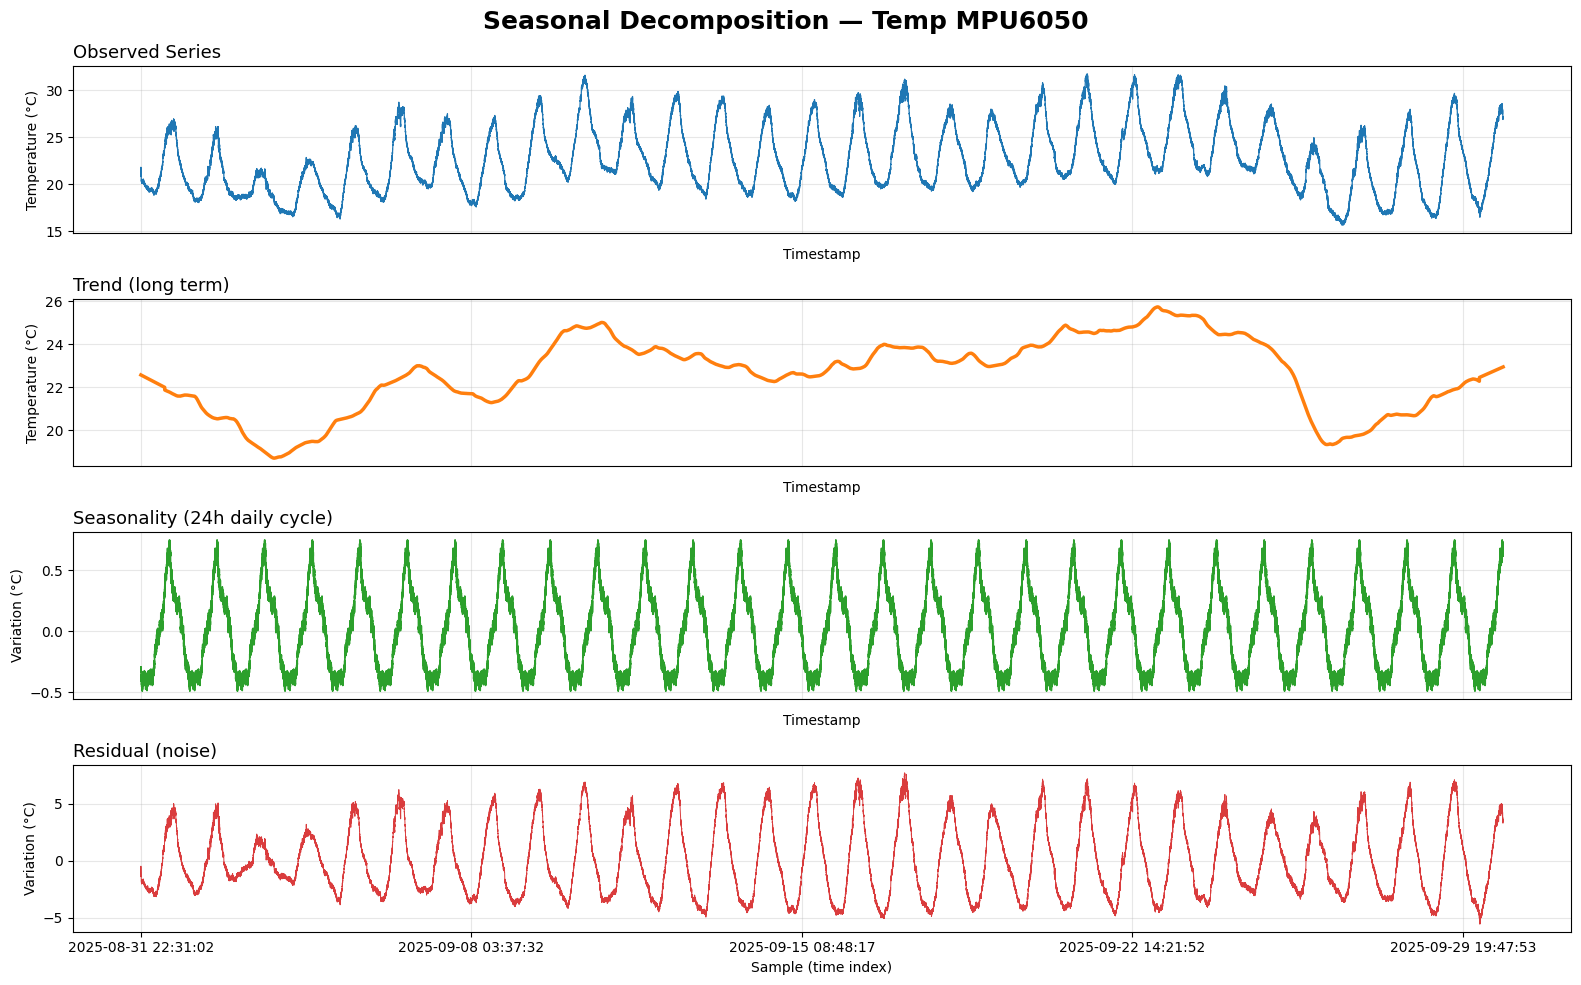

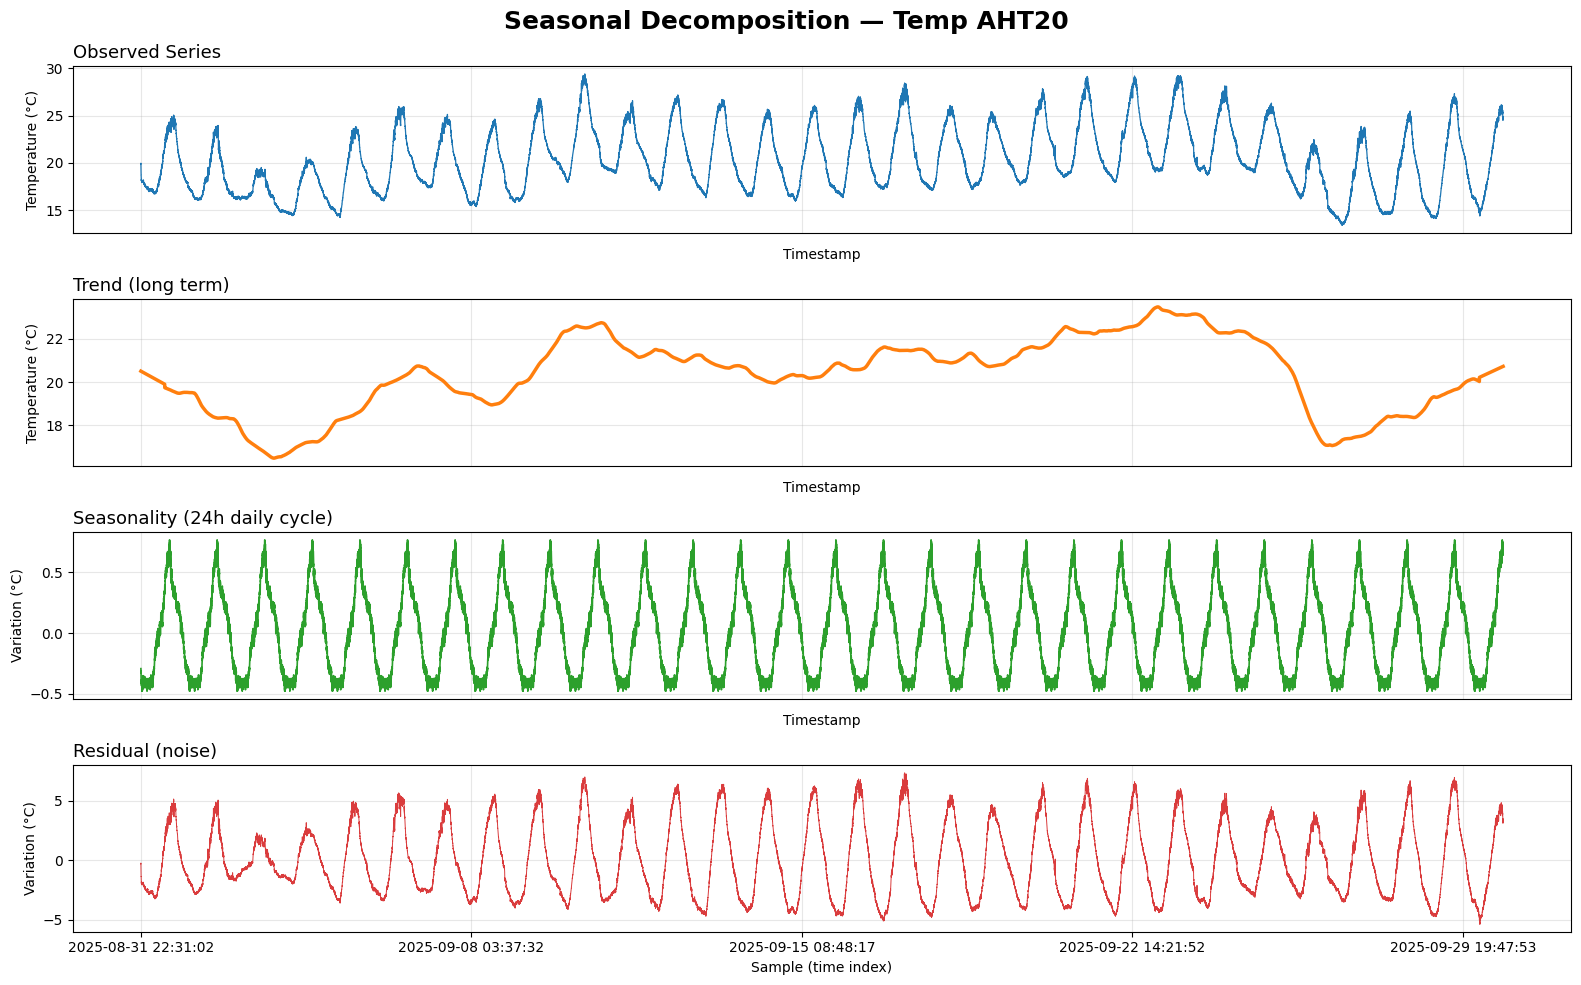

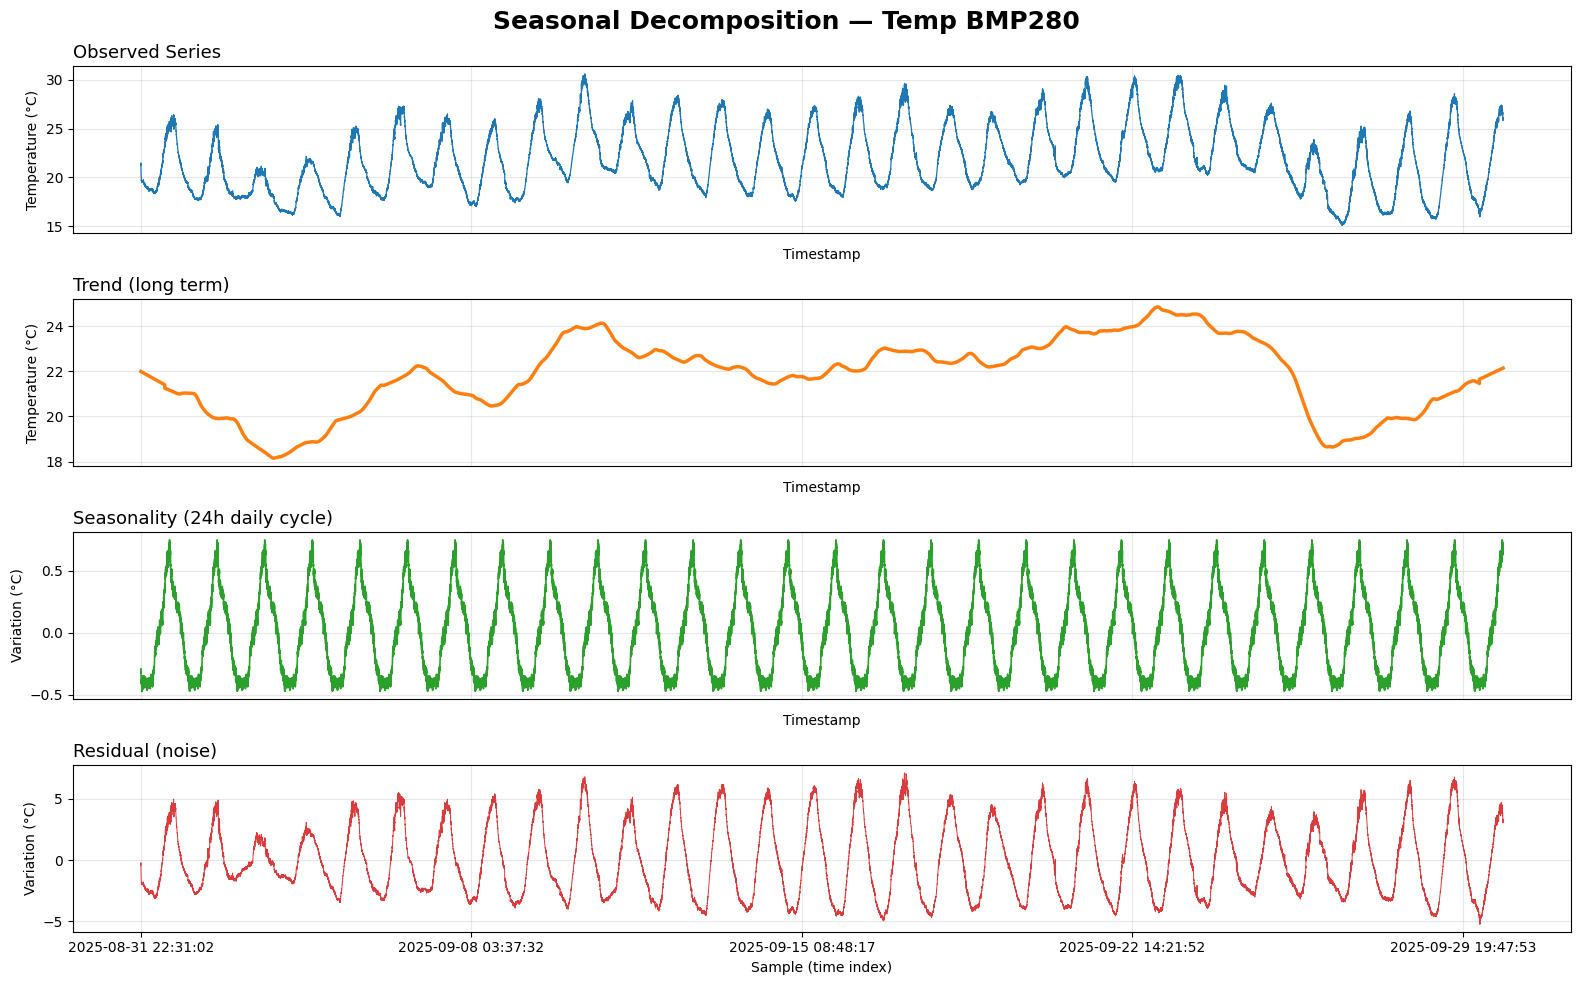

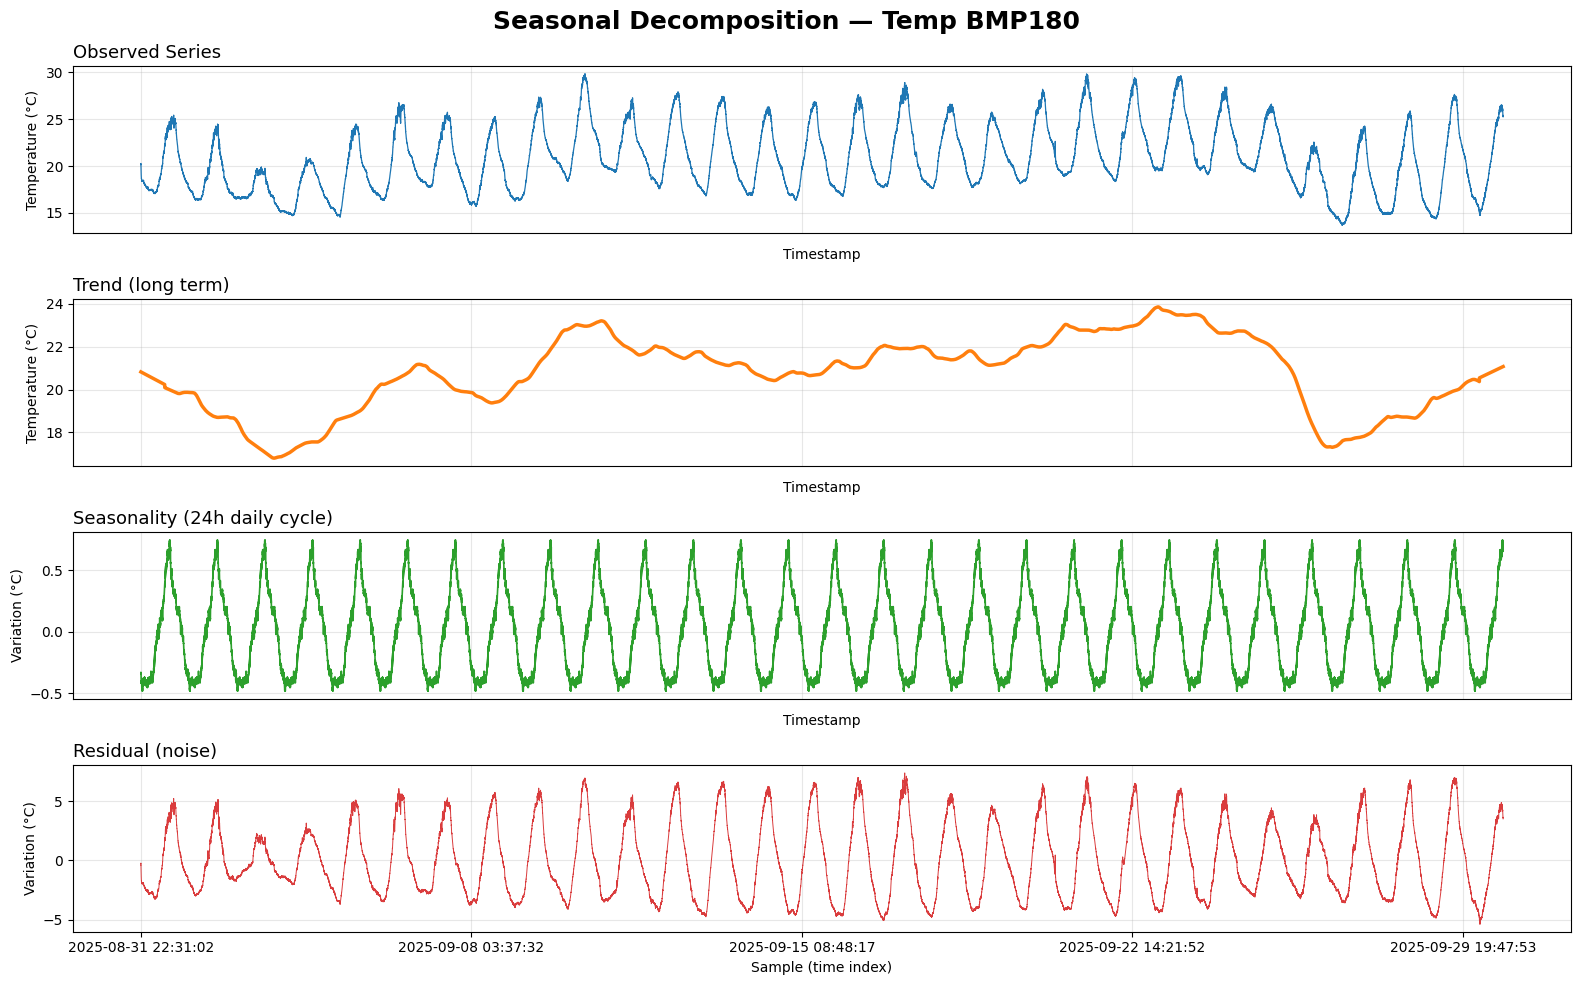

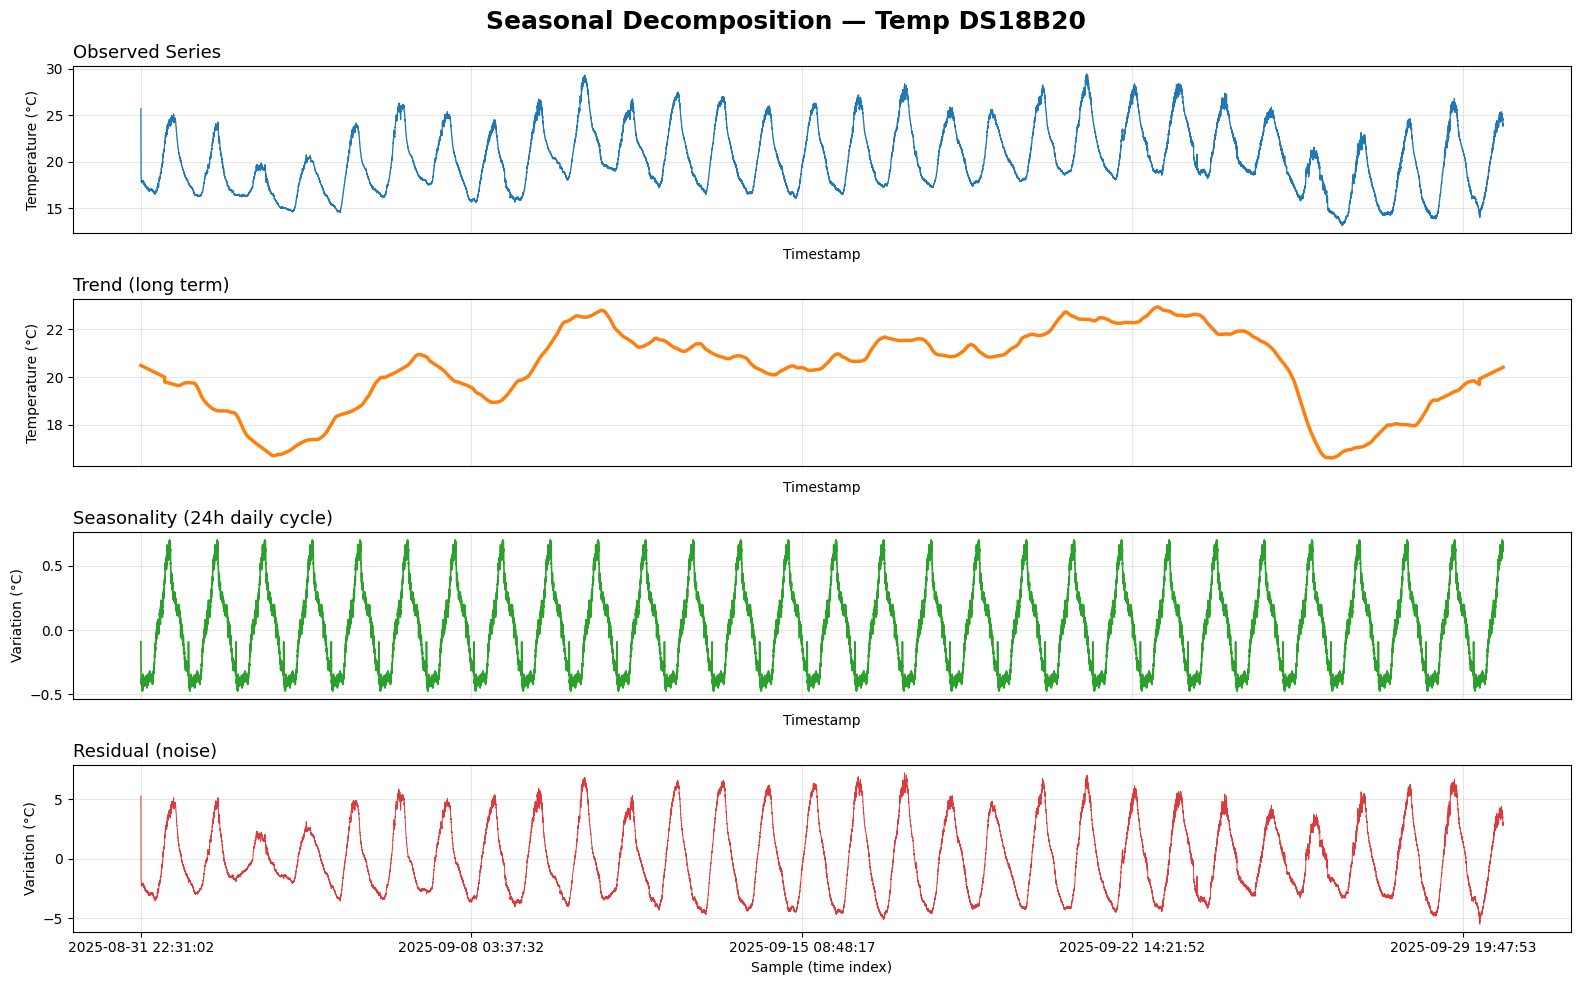

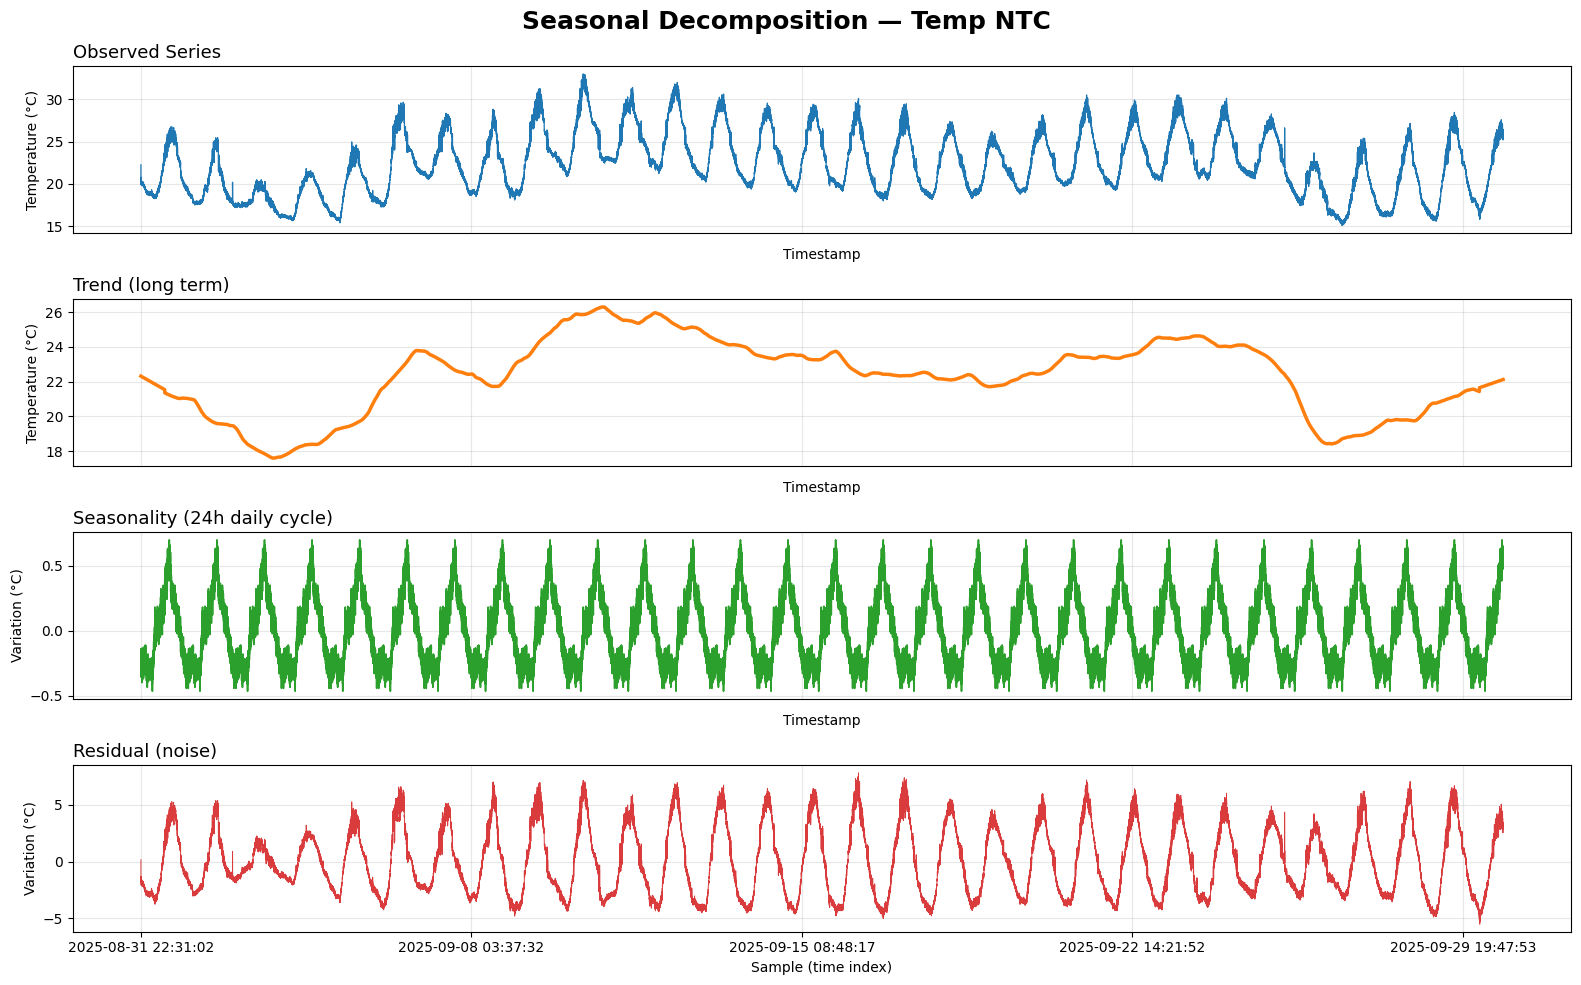

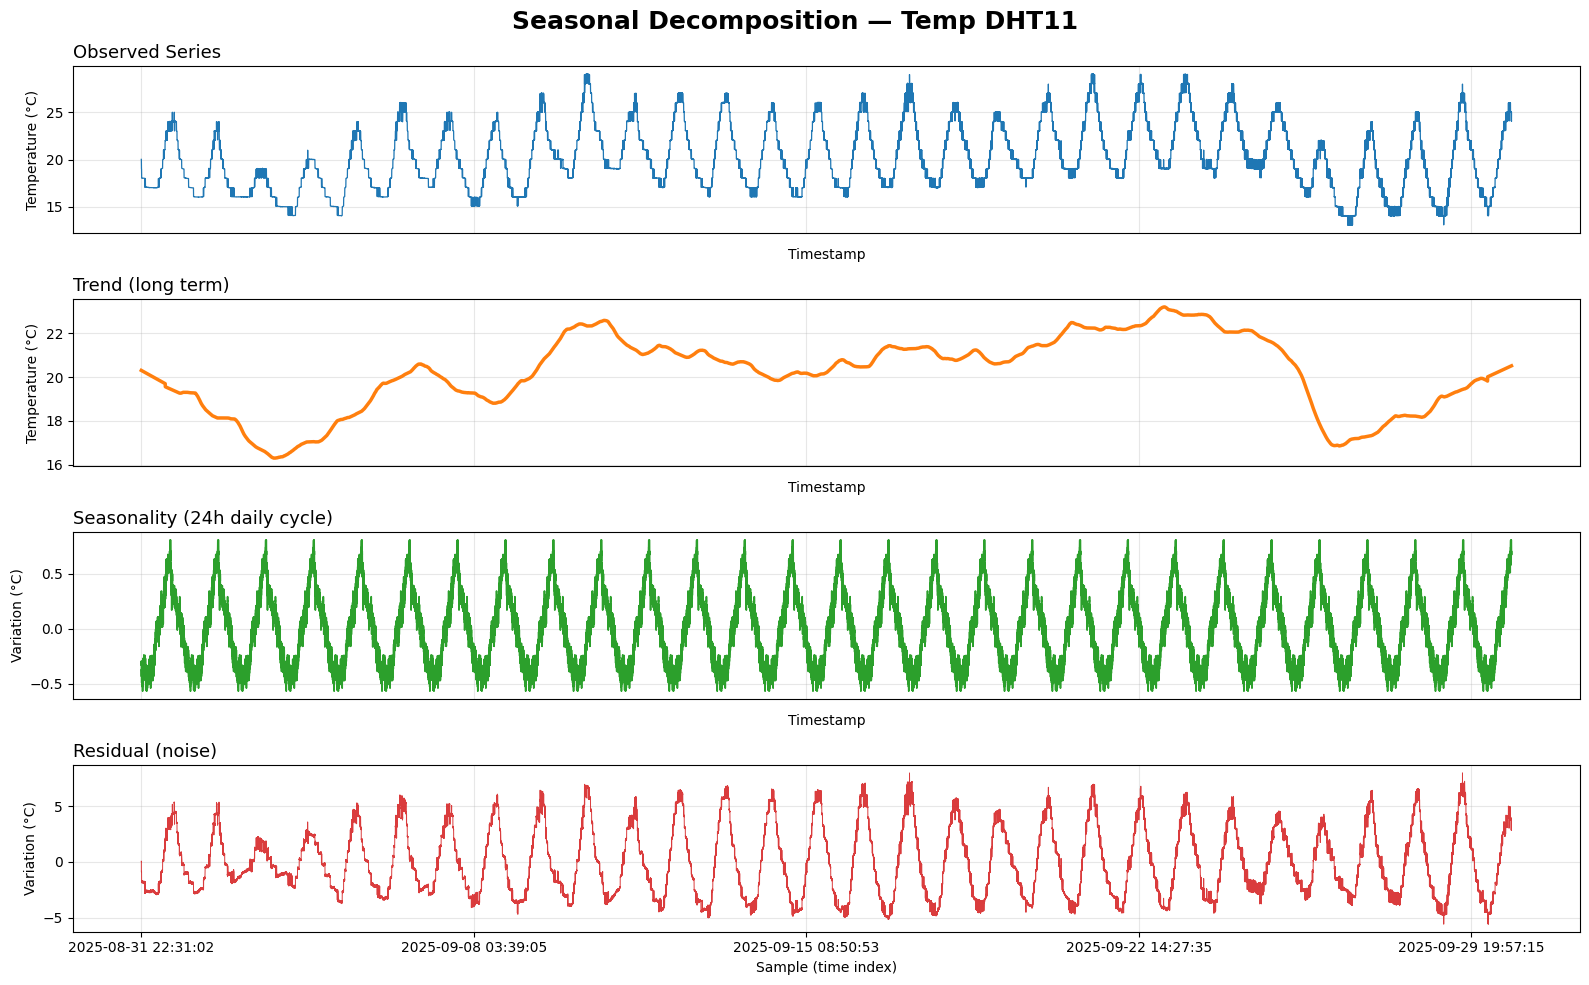

In [48]:
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

period = 24 * 60 * 2  #2880 points per day, considering measurements every 30 seconds
temp_cols = ['Temp_MPU6050_C', 'Temp_AHT20_C', 'Temp_BMP280_C',
             'Temp_BMP180_C', 'Temp_DS18B20_C', 'Temp_NTC_C', 'Temp_DHT11_C'] #all temperature sensors

for col in temp_cols: #for all temperature sensors
    serie = df[[col, 'Timestamp']].dropna().set_index('Timestamp')[col] #Clean series without error data
    decomposition = seasonal_decompose(# Seasonal decomposition, decomposes a time series into:
                                       # trend, seasonality and residual
        serie,
        model='additive', #series = trend + seasonality + residual (additive model)
        period=period,#the period in which data repeats, in this case we consider daily cycle
        extrapolate_trend='freq' #avoids NaNs at the edges
    )

    #Creates the 4 graphs for each SENSOR
    fig, axes = plt.subplots(4, 1, figsize=(16, 10), dpi=100)
    fig.suptitle(f'Seasonal Decomposition — {col.replace("_C", "").replace("_", " ")}',
                 fontsize=18, fontweight='bold', y=0.98)

    #OBSERVED
    decomposition.observed.plot(ax=axes[0], color='#1f77b4', linewidth=0.9)
    axes[0].set_title('Observed Series', fontsize=13, loc='left')
    axes[0].set_ylabel('Temperature (°C)')
    axes[0].grid(True, alpha=0.3)
    axes[0].set_xticklabels([])
    axes[0].tick_params(bottom=False)

    #TREND
    decomposition.trend.plot(ax=axes[1], color='#ff7f0e', linewidth=2.5)
    axes[1].set_title('Trend (long term)', fontsize=13, loc='left')
    axes[1].set_ylabel('Temperature (°C)')
    axes[1].grid(True, alpha=0.3)
    axes[1].set_xticklabels([])
    axes[1].tick_params(bottom=False)

    #SEASONALITY
    decomposition.seasonal.plot(ax=axes[2], color='#2ca02c', linewidth=1.2)
    axes[2].set_title('Seasonality (24h daily cycle)', fontsize=13, loc='left')
    axes[2].set_ylabel('Variation (°C)')
    axes[2].grid(True, alpha=0.3)
    axes[2].set_xticklabels([])
    axes[2].tick_params(bottom=False)

    #RESIDUAL
    decomposition.resid.plot(ax=axes[3], color='#d62728', linewidth=0.7, alpha=0.9)
    axes[3].set_title('Residual (noise)', fontsize=13, loc='left')
    axes[3].set_ylabel('Variation (°C)')
    axes[3].set_xlabel('Sample (time index)')
    axes[3].grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show() #Opens a new window for each sensor

In [49]:
import pandas as pd
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose

metrics = [] #saves evaluation metrics

for col in temp_cols: #for each sensor
    if df[col].dropna().shape[0] < 2 * period:
        continue
    decomposition = seasonal_decompose(df[col].dropna(), model='additive', period=period)#temperature series for each sensor
    #decomposition values
    obs = decomposition.observed
    trend = decomposition.trend
    season = decomposition.seasonal
    resid = decomposition.resid
    #adds to the metrics vector created above
    metrics.append({
        'Sensor': col.replace('Temp_', '').replace('_C', ''),
        'Mean_°C': obs.mean(),
        'Std_°C': obs.std(),
        'Total_Amplitude': obs.max() - obs.min(),
        'Trend_Var': trend.max() - trend.min(),
        'Seasonal_Amplitude': season.max() - season.min(),
        'Residual_Std': resid.std(),
        'Residual_Max': resid.abs().max(),
        '%_Trend_Var': (trend.var() / obs.var()) * 100,
        '%_Seasonal_Var': (season.var() / obs.var()) * 100,
        '%_Residual_Var': (resid.var() / obs.var()) * 100,
    })
df_metrics = pd.DataFrame(metrics)#dataframe for metrics

#creates display table
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.float_format', '{:.3f}'.format)
display(df_metrics)# Display complete table

,Sensor,Mean_°C,Std_°C,Total_Amplitude,Trend_Var,Seasonal_Amplitude,Residual_Std,Residual_Max,%_Trend_Var,%_Seasonal_Var,%_Residual_Var
0,MPU6050,22.595,3.505,16.090,7.020,1.022,3.125,7.644,24.261,0.511,79.517
1,AHT20,20.329,3.452,15.950,6.996,1.036,3.062,7.296,24.929,0.589,78.643
2,BMP280,21.803,3.351,15.470,6.695,1.015,2.981,7.084,24.457,0.606,79.151
3,BMP180,20.729,3.544,16.140,7.062,1.004,3.145,7.336,24.812,0.553,78.731
4,DS18B20,20.288,3.445,16.250,6.321,0.980,3.067,7.201,24.447,0.527,79.241
5,NTC,22.304,3.616,17.880,8.699,1.002,2.953,7.755,36.451,0.318,66.698
6,DHT11,20.165,3.465,16.020,6.903,1.184,3.075,8.173,24.988,0.537,78.760


All sensors show very consistent daily seasonal patterns ( aprox 1°C amplitude), with clearly defined 24h cycles. The long-term trend varies between 16-22°C, showing a sharp drop at the end of the period (likely real climate change). The residual dominates the variance ( aprox 79% across all sensors), indicating that most variation is random noise, not predictable patterns. The MPU6050 and NTC sensors show higher average temperature (aprox 22-23°C), while DHT11, BMP180 and AHT20 are cooler ( aprox 20°C). The decomposition confirms that the data is highly noisy but with stable and reliable daily seasonality for temporal analysis.

### 2.1.2. Humidity

------------------------

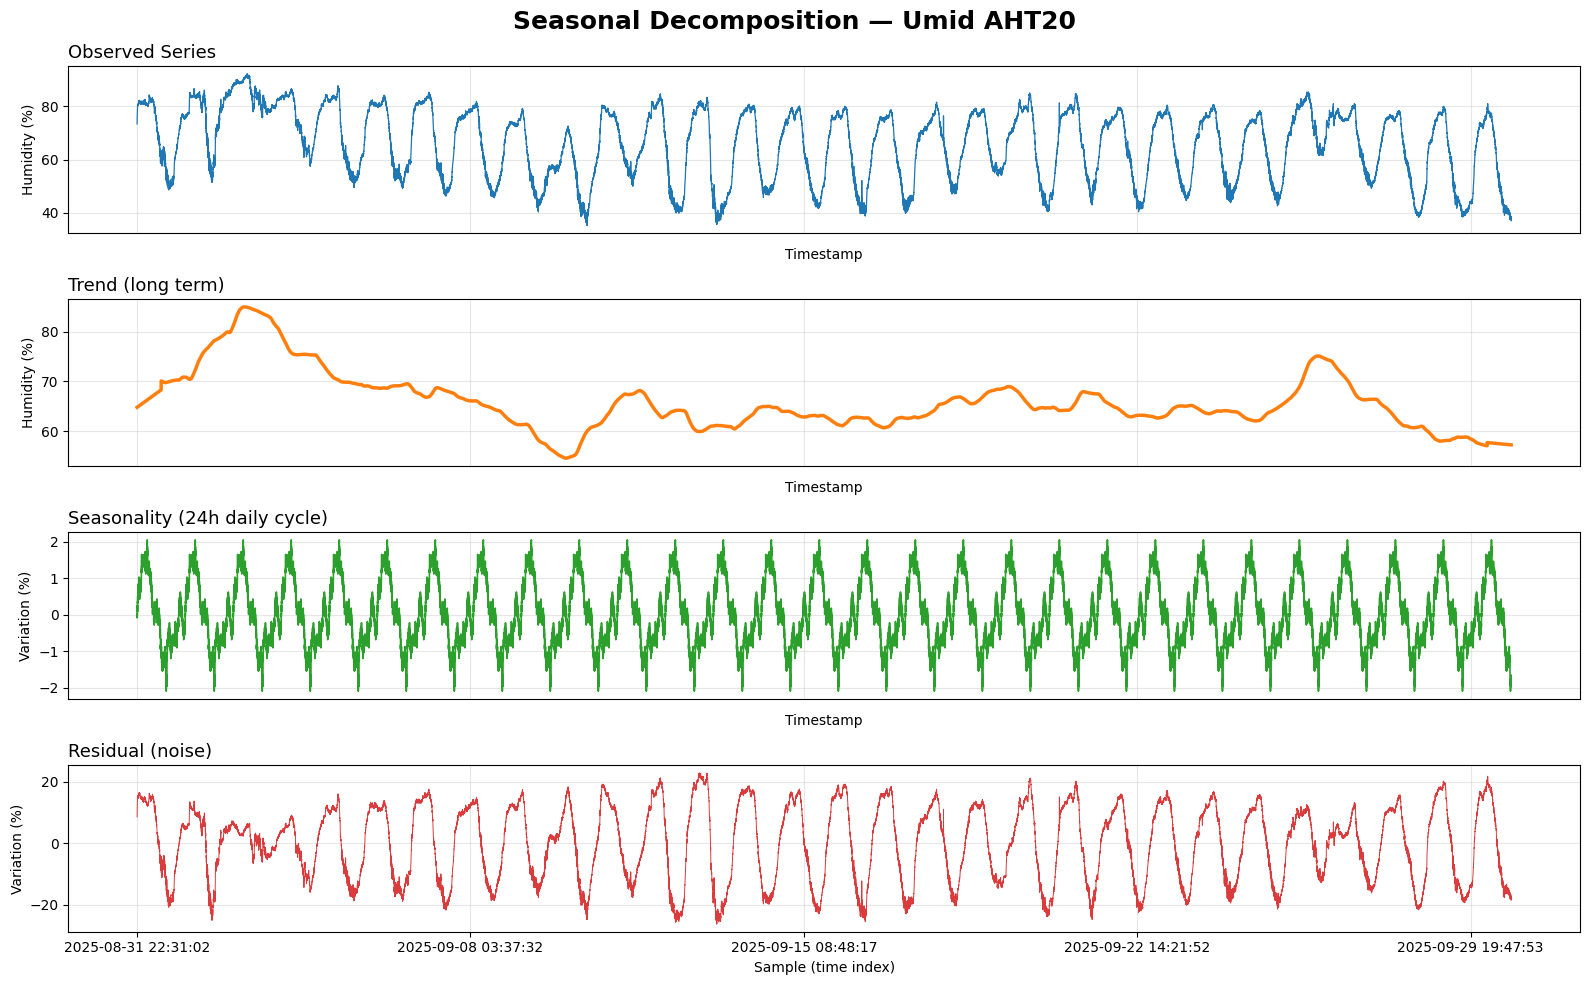

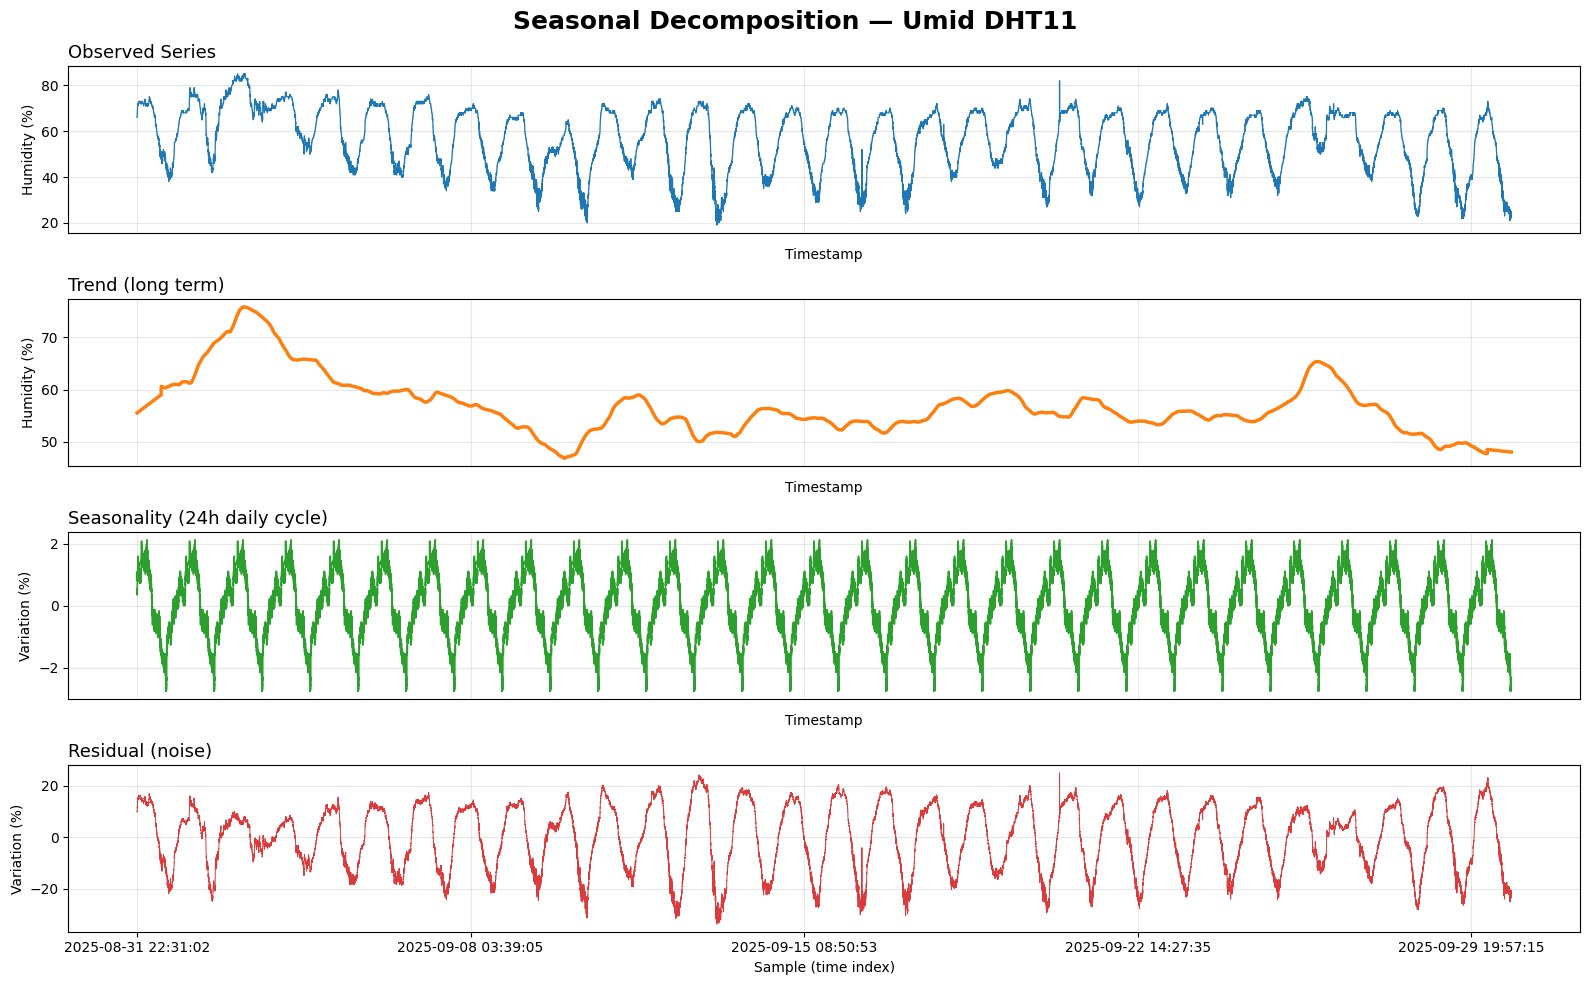

In [50]:
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

period = 24 * 60 * 2  #2880 points per day, considering measurements every 30 seconds
humid_cols = ['Umid_AHT20_pct', 'Umid_DHT11_pct'] #all humidity sensors

for col in humid_cols: #for all humidity sensors
    serie = df[[col, 'Timestamp']].dropna().set_index('Timestamp')[col] #Clean series without error data
    decomposition = seasonal_decompose(# Seasonal decomposition, decomposes a time series into:
                                       # trend, seasonality and residual
        serie,
        model='additive', #series = trend + seasonality + residual (additive model)
        period=period,#the period in which data repeats, in this case we consider daily cycle
        extrapolate_trend='freq' #avoids NaNs at the edges
    )

    #Creates the 4 graphs for each SENSOR
    fig, axes = plt.subplots(4, 1, figsize=(16, 10), dpi=100)
    fig.suptitle(f'Seasonal Decomposition — {col.replace("_pct", "").replace("_", " ")}',
                 fontsize=18, fontweight='bold', y=0.98)

    #OBSERVED
    decomposition.observed.plot(ax=axes[0], color='#1f77b4', linewidth=0.9)
    axes[0].set_title('Observed Series', fontsize=13, loc='left')
    axes[0].set_ylabel('Humidity (%)')
    axes[0].grid(True, alpha=0.3)
    axes[0].set_xticklabels([])
    axes[0].tick_params(bottom=False)

    #TREND
    decomposition.trend.plot(ax=axes[1], color='#ff7f0e', linewidth=2.5)
    axes[1].set_title('Trend (long term)', fontsize=13, loc='left')
    axes[1].set_ylabel('Humidity (%)')
    axes[1].grid(True, alpha=0.3)
    axes[1].set_xticklabels([])
    axes[1].tick_params(bottom=False)

    #SEASONALITY
    decomposition.seasonal.plot(ax=axes[2], color='#2ca02c', linewidth=1.2)
    axes[2].set_title('Seasonality (24h daily cycle)', fontsize=13, loc='left')
    axes[2].set_ylabel('Variation (%)')
    axes[2].grid(True, alpha=0.3)
    axes[2].set_xticklabels([])
    axes[2].tick_params(bottom=False)

    #RESIDUAL
    decomposition.resid.plot(ax=axes[3], color='#d62728', linewidth=0.7, alpha=0.9)
    axes[3].set_title('Residual (noise)', fontsize=13, loc='left')
    axes[3].set_ylabel('Variation (%)')
    axes[3].set_xlabel('Sample (time index)')
    axes[3].grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show() #Opens a new window for each sensor

In [51]:
import pandas as pd
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose

metrics = [] #saves evaluation metrics

for col in humid_cols: #for each sensor
    if df[col].dropna().shape[0] < 2 * period:
        continue
    decomposition = seasonal_decompose(df[col].dropna(), model='additive', period=period)#humidity series for each sensor
    #decomposition values
    obs = decomposition.observed
    trend = decomposition.trend
    season = decomposition.seasonal
    resid = decomposition.resid
    #adds to the metrics vector created above
    metrics.append({
        'Sensor': col.replace('Umid_', '').replace('_pct', ''),
        'Mean_%': obs.mean(),
        'Std_%': obs.std(),
        'Total_Amplitude': obs.max() - obs.min(),
        'Trend_Var': trend.max() - trend.min(),
        'Seasonal_Amplitude': season.max() - season.min(),
        'Residual_Std': resid.std(),
        'Residual_Max': resid.abs().max(),
        '%_Trend_Var': (trend.var() / obs.var()) * 100,
        '%_Seasonal_Var': (season.var() / obs.var()) * 100,
        '%_Residual_Var': (resid.var() / obs.var()) * 100,
    })
df_metrics = pd.DataFrame(metrics)#dataframe for metrics

#creates display table
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.float_format', '{:.3f}'.format)
display(df_metrics)# Display complete table

,Sensor,Mean_%,Std_%,Total_Amplitude,Trend_Var,Seasonal_Amplitude,Residual_Std,Residual_Max,%_Trend_Var,%_Seasonal_Var,%_Residual_Var
0,AHT20,65.946,13.343,56.690,30.419,2.637,12.227,25.851,18.793,0.144,83.976
1,DHT11,56.830,13.698,66.000,29.008,3.556,12.707,33.219,16.345,0.234,86.054


Both humidity sensors show strong daily seasonality (amplitude from 2.6 to 3.6%) with inverse correlation to temperature (humidity drops when temperature rises). The long-term trend varies significantly (46-83% for AHT20, 25-90% for DHT11), showing clear environmental changes throughout the measurement period. DHT11 is consistently drier (mean of 57%) than AHT20 (66%), with higher total amplitude (66% versus 57%), indicating sensor difference or placement effects. The residual noise dominates (84 to 86% of variance), similar to temperature sensors, showing high measurement variability. Both sensors exhibit very consistent 24h cycles, but with substantial random fluctuations, making the seasonal component predictable, but the overall signal quite noisy.

### 2.1.3. Pressure

-----------

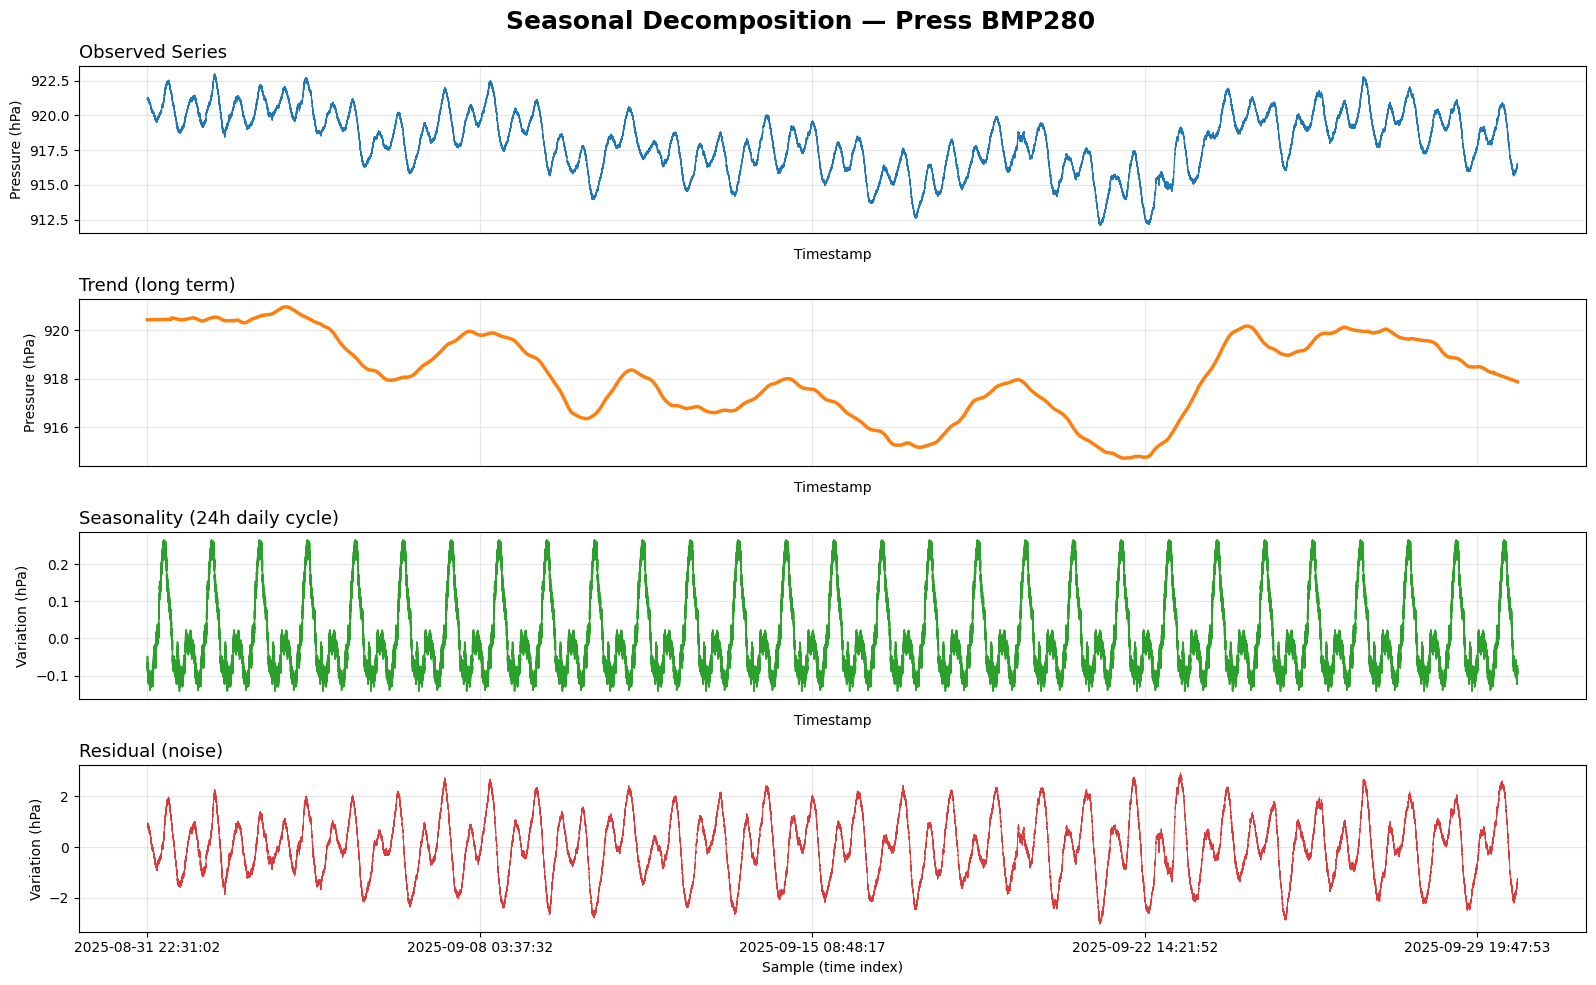

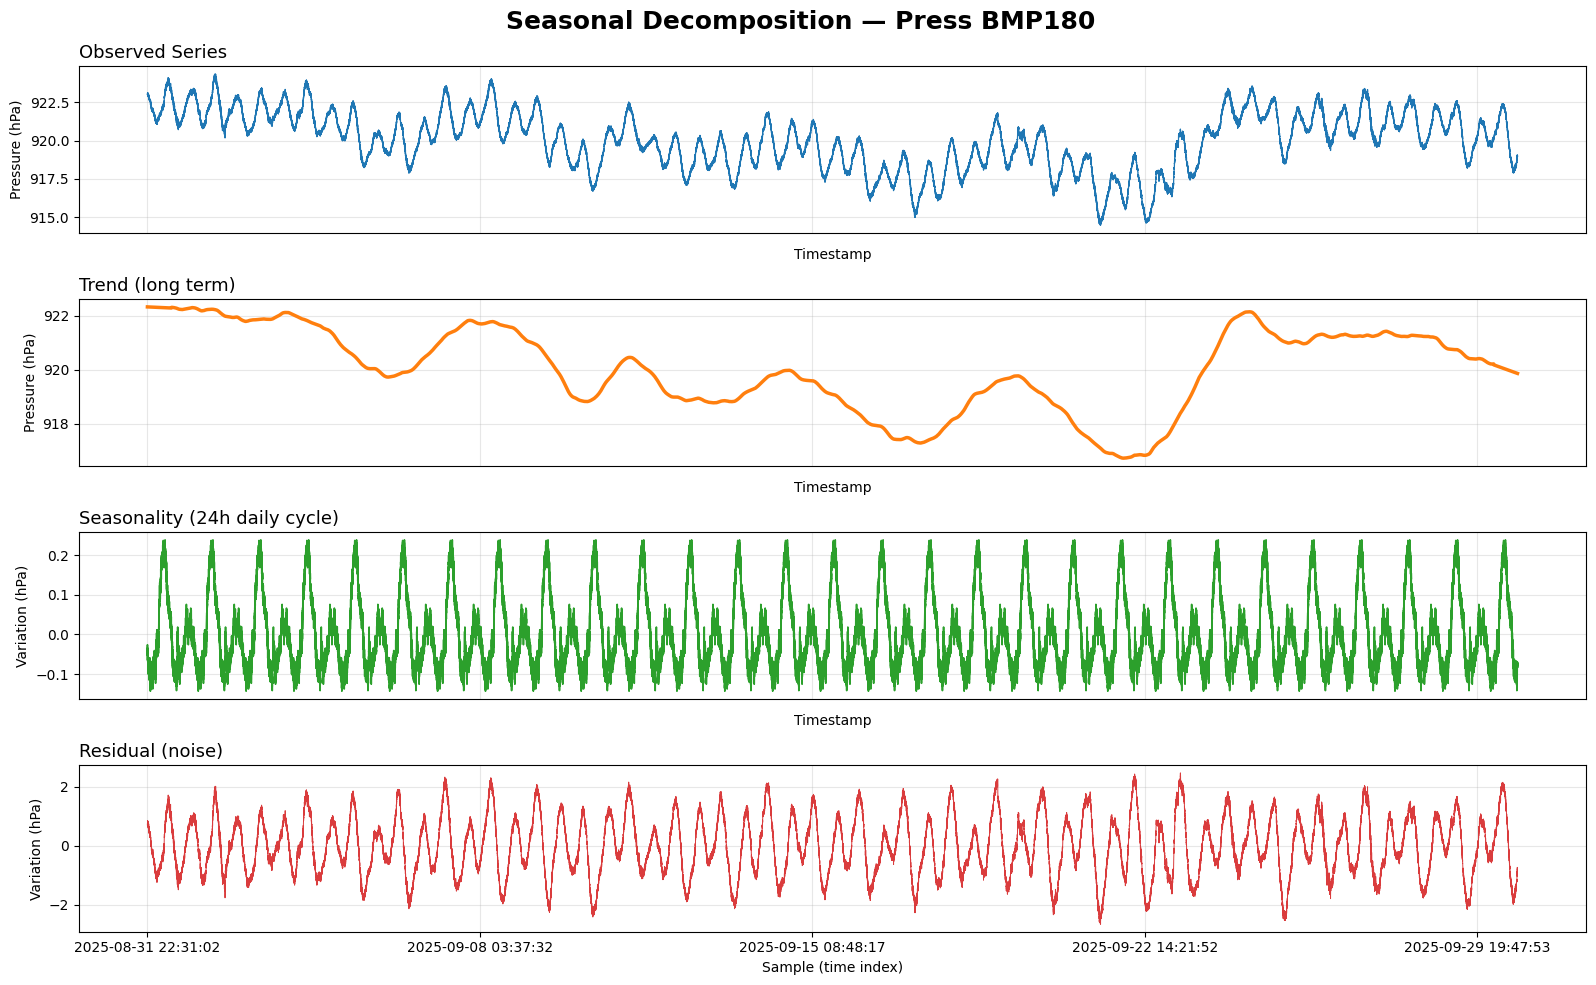

In [52]:
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

period = 24 * 60 * 2  #2880 points per day, considering measurements every 30 seconds
press_cols = ['Press_BMP280_hPa', 'Press_BMP180_hPa'] #all pressure sensors

for col in press_cols: #for all pressure sensors
    serie = df[[col, 'Timestamp']].dropna().set_index('Timestamp')[col] #Clean series without error data
    decomposition = seasonal_decompose(# Seasonal decomposition, decomposes a time series into:
                                       # trend, seasonality and residual
        serie,
        model='additive', #series = trend + seasonality + residual (additive model)
        period=period,#the period in which data repeats, in this case we consider daily cycle
        extrapolate_trend='freq' #avoids NaNs at the edges
    )

    #Creates the 4 graphs for each SENSOR
    fig, axes = plt.subplots(4, 1, figsize=(16, 10), dpi=100)
    fig.suptitle(f'Seasonal Decomposition — {col.replace("_hPa", "").replace("_", " ")}',
                 fontsize=18, fontweight='bold', y=0.98)

    #OBSERVED
    decomposition.observed.plot(ax=axes[0], color='#1f77b4', linewidth=0.9)
    axes[0].set_title('Observed Series', fontsize=13, loc='left')
    axes[0].set_ylabel('Pressure (hPa)')
    axes[0].grid(True, alpha=0.3)
    axes[0].set_xticklabels([])
    axes[0].tick_params(bottom=False)

    #TREND
    decomposition.trend.plot(ax=axes[1], color='#ff7f0e', linewidth=2.5)
    axes[1].set_title('Trend (long term)', fontsize=13, loc='left')
    axes[1].set_ylabel('Pressure (hPa)')
    axes[1].grid(True, alpha=0.3)
    axes[1].set_xticklabels([])
    axes[1].tick_params(bottom=False)

    #SEASONALITY
    decomposition.seasonal.plot(ax=axes[2], color='#2ca02c', linewidth=1.2)
    axes[2].set_title('Seasonality (24h daily cycle)', fontsize=13, loc='left')
    axes[2].set_ylabel('Variation (hPa)')
    axes[2].grid(True, alpha=0.3)
    axes[2].set_xticklabels([])
    axes[2].tick_params(bottom=False)

    #RESIDUAL
    decomposition.resid.plot(ax=axes[3], color='#d62728', linewidth=0.7, alpha=0.9)
    axes[3].set_title('Residual (noise)', fontsize=13, loc='left')
    axes[3].set_ylabel('Variation (hPa)')
    axes[3].set_xlabel('Sample (time index)')
    axes[3].grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show() #Opens a new window for each sensor

In [53]:
import pandas as pd
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose

metrics = [] #saves evaluation metrics

for col in press_cols: #for each sensor
    if df[col].dropna().shape[0] < 2 * period:
        continue
    decomposition = seasonal_decompose(df[col].dropna(), model='additive', period=period)#pressure series for each sensor
    #decomposition values
    obs = decomposition.observed
    trend = decomposition.trend
    season = decomposition.seasonal
    resid = decomposition.resid
    #adds to the metrics vector created above
    metrics.append({
        'Sensor': col.replace('Press_', '').replace('_hPa', ''),
        'Mean_hPa': obs.mean(),
        'Std_hPa': obs.std(),
        'Total_Amplitude': obs.max() - obs.min(),
        'Trend_Var': trend.max() - trend.min(),
        'Seasonal_Amplitude': season.max() - season.min(),
        'Residual_Std': resid.std(),
        'Residual_Max': resid.abs().max(),
        '%_Trend_Var': (trend.var() / obs.var()) * 100,
        '%_Seasonal_Var': (season.var() / obs.var()) * 100,
        '%_Residual_Var': (resid.var() / obs.var()) * 100,
    })
df_metrics = pd.DataFrame(metrics)#dataframe for metrics

#creates display table
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.float_format', '{:.3f}'.format)
display(df_metrics)# Display complete table

,Sensor,Mean_hPa,Std_hPa,Total_Amplitude,Trend_Var,Seasonal_Amplitude,Residual_Std,Residual_Max,%_Trend_Var,%_Seasonal_Var,%_Residual_Var
0,BMP280,918.147,2.147,10.890,6.233,0.333,1.206,3.049,63.326,0.133,31.528
1,BMP180,920.040,1.880,9.870,5.588,0.333,0.993,2.657,65.881,0.138,27.910


Both pressure sensors show very weak daily seasonality (only 0.33 hPa amplitude), much smaller compared to temperature and humidity, indicating atmospheric pressure is less affected by diurnal cycles. The long-term trend dominates the variance (63-66%), showing significant atmospheric pressure changes over the measurement period, with variations of 5.6 to 6.2 hPa. BMP180 measures consistently higher (mean 920 hPa) than BMP280 (918 hPa), likely due to calibration differences or altitude sensitivity. The residual noise is much lower (28-32% of variance) compared to temperature and humidity sensors (79-86%), indicating pressure measurements are more stable and less noisy. Both sensors display nearly identical seasonal patterns but differ in absolute pressure readings, suggesting good agreement in detecting atmospheric changes despite systematic offset.

# 3. Conclusion


---------------------

The seasonal decomposition reveals that **all sensors exhibit strong and consistent 24h daily cycles**, with temperature showing 1°C amplitude, humidity 2.6-3.6%, and pressure only 0.33 hPa. **Residual noise dominates temperature and humidity** (79-86% of variance), while **pressure is more stable** (28-32% residual variance), indicating atmospheric pressure measurements are inherently less noisy. The **long-term trends** capture real environmental changes, with notable drops at the end of the measurement period across all variables. **Humidity inversely correlates with temperature**, confirming expected atmospheric behavior. Overall, the decomposition successfully separates predictable daily patterns from long-term trends and random fluctuations, validating the data quality and revealing that sensor placement or calibration differences explain systematic offsets between similar sensors.Tentar novamente